In [118]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import pickle
from tqdm import tqdm
from data.util.paths import DATA_PATH
tqdm.pandas()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
from lib.processing import save_to_pkl, load_from_pkl
from data.scripts.project_data import DataLoader

In [82]:
concat_df = load_from_pkl('concat')

In [83]:
concat_columns = set(concat_df.columns)

In [92]:
get_col_set = lambda x: set([column for column in concat_columns if x in column])

format_description_columns = get_col_set('format_description_')
format_name_columns = get_col_set('format_name_')
format_columns = set([*format_description_columns,*format_name_columns,'format_text_clean','format_quantity'])


In [85]:
superregion_columns = get_col_set('superregion_')
region_columns = get_col_set('region_')
country_columns = get_col_set('country_')
geography_columns = set([*superregion_columns,*region_columns,*country_columns])


In [88]:
period_columns = get_col_set('_period')
era_columns = get_col_set('_era')

In [86]:
genre_columns = get_col_set('genre_')
style_columns = get_col_set('style_')

In [93]:
rest_columns = concat_columns-format_columns-geography_columns-genre_columns-style_columns-period_columns-era_columns

In [94]:
rest_columns

{'artist',
 'artist_clean',
 'average_rating',
 'community_have',
 'community_want',
 'country',
 'format_description',
 'format_text',
 'formats',
 'genre',
 'have',
 'highest',
 'label',
 'label_clean',
 'last_sold',
 'lowest',
 'market_price',
 'market_value',
 'master_id',
 'median',
 'no_of_days_since_last_sale',
 'number_of_tracks',
 'rating_count',
 'release_id',
 'release_url',
 'running_time',
 'standards_count',
 'style',
 'thumb_url',
 'title',
 'track_titles',
 'units_for_sale',
 'want',
 'year'}

## Visualizations
- Pairplot of all Numerics
- Evolution of market_value over time
- Most frequent genres
- Most frequent styles
- Most frequent formats
- Geographical mapping
- how many releases per year

In [ ]:
sns.pairplot(concat_df[rest_columns],cmap='spectral')

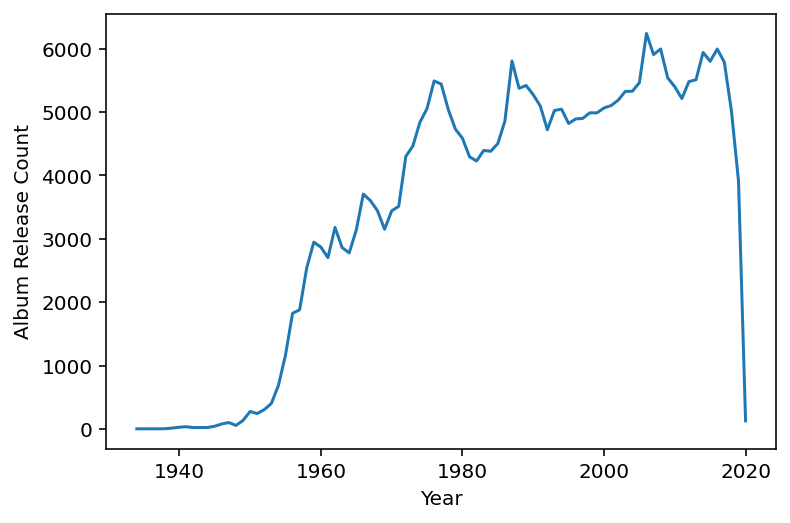

In [115]:
plt.plot(concat_df.groupby(by='year')['market_value'].count())
plt.xlabel('Year')
plt.ylabel('Album Release Count')
plt.show()

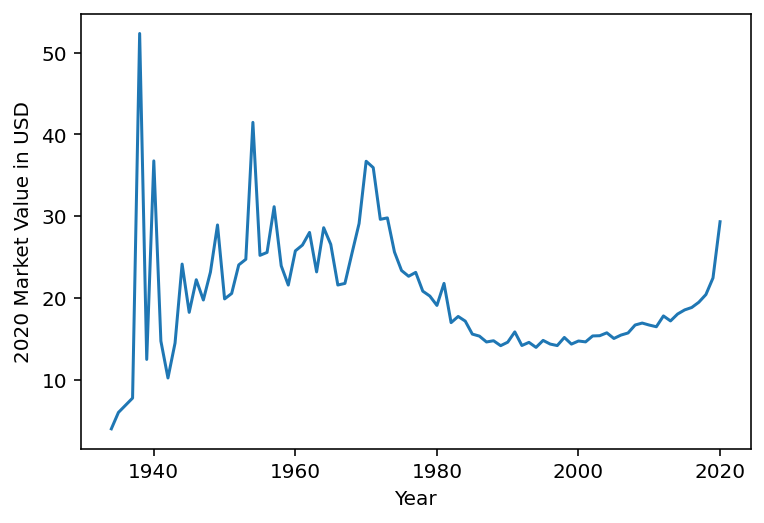

In [105]:
plt.plot(concat_df.groupby(by='year')['market_value'].mean())
plt.xlabel('Year')
plt.ylabel('2020 Market Value in USD')
plt.show()

In [117]:
import geopandas as gpd

In [119]:
map_df = gpd.read_file(os.path.join(DATA_PATH,'countries/ne_110m_admin_0_countries.shp'))

In [157]:
from data.util.environment_variables import COUNTRY_CODES, M49_TO_ISO3

In [147]:
visualization_countries = list(filter(lambda x: x not in ['country_yugoslavia','country_ussr','country_taiwan'],country_columns))
country_album_count = concat_df[visualization_countries].sum()

In [145]:
country_codes = pd.Series([COUNTRY_CODES[country.split('_')[-1]] for country in visualization_countries],index=visualization_countries)

In [154]:
country_df = pd.DataFrame(country_album_count)

In [155]:
country_df['codes'] = country_codes

In [161]:
country_df['ISO_A3'] = country_df.loc[:,'codes'].map(M49_TO_ISO3) 

In [163]:
country_df

,0,codes,ISO_A3
country_sint maarten (dutch part),3,534,SXM
country_finland,1716,246,FIN
country_belarus,11,112,BLR
country_bahamas,7,044,BHS
country_china,67,156,CHN
...,...,...,...
country_nigeria,75,566,NGA
country_liechtenstein,11,438,LIE
country_costa rica,22,188,CRI
country_virgin islands (british),2,092,VGB


In [164]:
merge = map_df.set_index('ISO_A3').join(country_df.set_index('ISO_A3'))

In [177]:
merge.fillna(0,inplace=True)

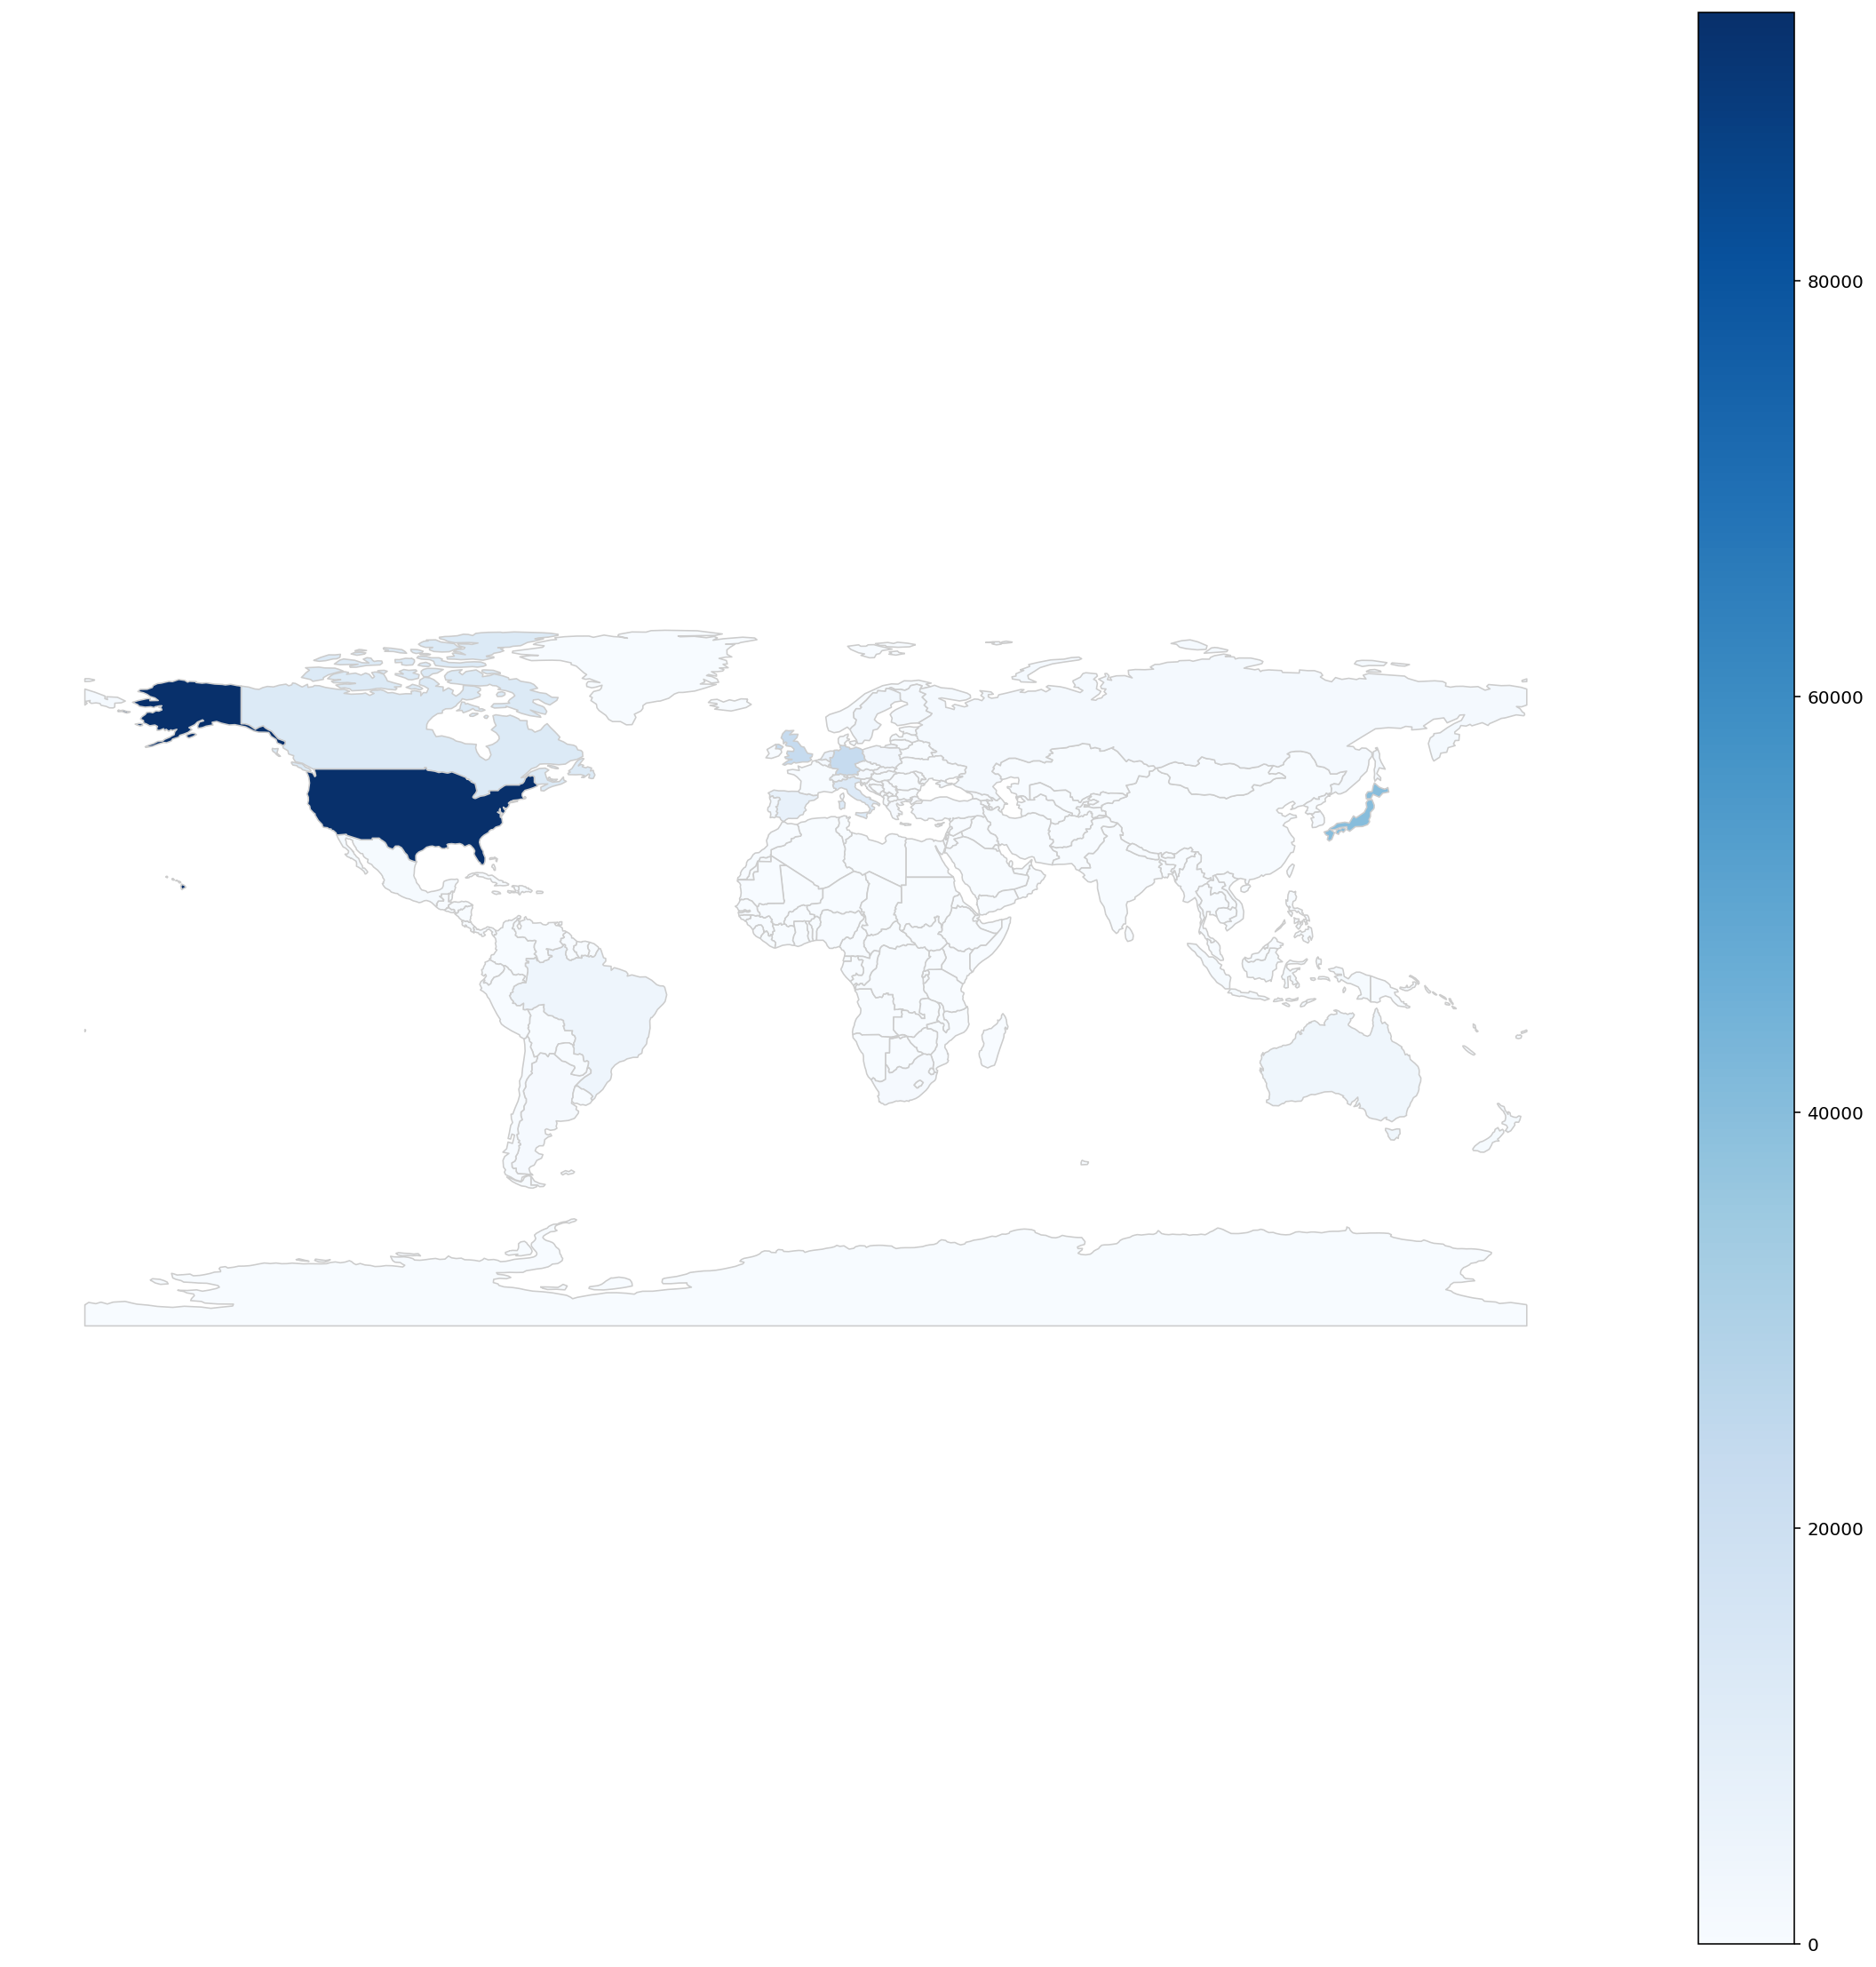

In [183]:
vmin, vmax = min(merge[0]),max(merge[0])
fig, ax = plt.subplots(1,figsize=(20,20))
merge.plot(column=0,cmap='Blues',linewidth=0.8,ax=ax,edgecolor='0.8')
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='Blues',norm=plt.Normalize(vmin=vmin,vmax=vmax))
sm._a = []
cbar = fig.colorbar(sm)
plt.show()

# High Level Features
## Loading and Cleaning

In [31]:
data_loader = DataLoader()
high_level_features = data_loader.load_high_level_features()
high_level_feature_df = pd.DataFrame()
for feature_chunk in tqdm(high_level_features):
    high_level_feature_df = pd.concat([high_level_feature_df,feature_chunk],axis=0)

36it [08:30, 14.17s/it]


KeyError: "['index'] not found in axis"

In [35]:
high_level_feature_df = high_level_feature_df.reset_index(drop=True).drop('index',axis=1).astype({'release_id':np.uint32,'bitmap':np.uint8})

In [36]:
high_level_feature_df

,release_id,bitmap,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_1271,feature_1272,feature_1273,feature_1274,feature_1275,feature_1276,feature_1277,feature_1278,feature_1279,feature_1280
0,10000059,0,1.515982,0.985522,1.007454,0.000000,0.000000,0.038283,0.128865,1.145386,...,0.114205,0.541623,0.000000,0.749873,0.098970,0.000000,0.000000,0.005582,0.000000,0.271306
1,10000099,0,0.107666,0.012730,0.708745,0.038983,0.014043,0.034137,0.063565,0.571926,...,0.000000,0.330848,0.326690,0.526954,2.056569,0.004467,0.001381,0.000000,0.760751,0.000000
2,10000106,0,0.772954,1.777797,0.335263,0.000000,0.982789,0.181303,0.000000,0.456971,...,0.000000,0.012951,0.525019,0.000000,4.226579,0.000000,0.617199,0.000000,0.615453,0.000000
3,10000120,0,0.031700,0.000000,0.407634,0.000000,0.000000,0.000000,0.680883,0.136133,...,0.000000,0.025783,0.000000,0.072506,1.413647,0.037377,0.560480,0.000000,0.049533,0.304863
4,10000148,0,0.000000,2.523202,0.000000,0.143037,0.000000,0.000000,0.127924,0.416034,...,0.000000,0.361263,0.000000,0.333124,0.000000,0.000000,0.389682,0.028799,0.042345,0.944980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350325,9997153,1,0.699354,2.161860,0.111729,0.387642,0.000000,0.000000,0.000000,0.098190,...,3.471008,0.018930,0.000000,0.000000,0.000000,0.007879,0.000000,0.000000,0.382585,0.539629
350326,9997315,1,0.699354,2.161860,0.111729,0.387642,0.000000,0.000000,0.000000,0.098190,...,3.471008,0.018930,0.000000,0.000000,0.000000,0.007879,0.000000,0.000000,0.382585,0.539629
350327,9997396,1,0.699354,2.161860,0.111729,0.387642,0.000000,0.000000,0.000000,0.098190,...,3.471008,0.018930,0.000000,0.000000,0.000000,0.007879,0.000000,0.000000,0.382585,0.539629
350328,9997519,1,0.699354,2.161860,0.111729,0.387642,0.000000,0.000000,0.000000,0.098190,...,3.471008,0.018930,0.000000,0.000000,0.000000,0.007879,0.000000,0.000000,0.382585,0.539629


In [43]:
high_level_feature_df = high_level_feature_df.merge(concat_df.loc[:,'release_id'],on='release_id',how='right')

In [60]:
import umap

In [75]:
data = high_level_feature_df.drop(['release_id','bitmap'],axis=1).dropna(how='all')

In [65]:
reducer = umap.UMAP()

In [76]:
embedding = reducer.fit_transform(data)

/Users/simonhelmig/anaconda3/envs/exts-ml/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../anaconda3/envs/exts-ml/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/simonhelmig/anaconda3/envs/exts-ml/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..

In [77]:
embedding.shape

(297356, 2)

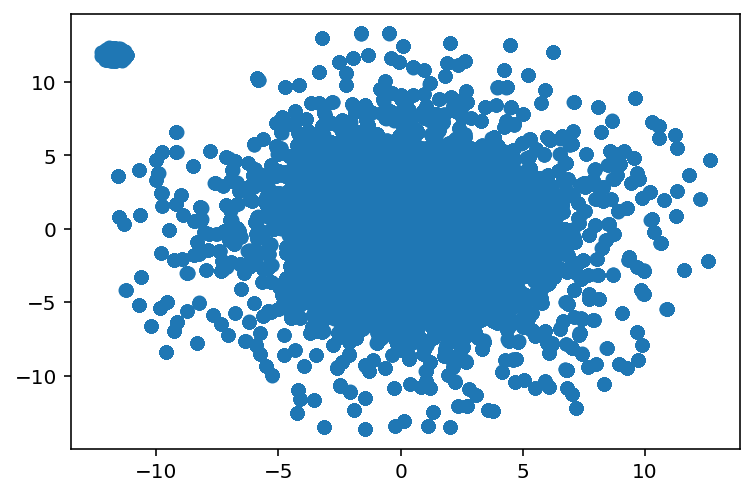

In [185]:
plt.scatter(embedding[:,0],embedding[:,1],cmap='Spectral')